# Python based Project – Learn to Build Image Caption Generator with CNN & LSTM



Image Caption Generator Model

So, to make our image caption generator model, we will be merging these architectures. It is also called a CNN-RNN model.

CNN is used for extracting features from the image. We will use the pre-trained model Xception. LSTM will use the information from CNN to help generate a description of the image.

## 1. First, we import all the necessary packages

In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

Using TensorFlow backend.
C:\Users\LENOVO\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## 2. Getting and performing data cleaning

**We will define 5 functions:**

**load_doc( filename ) –** For loading the document file and reading the contents inside the file into a string.
**all_img_captions( filename ) –** This function will create a descriptions dictionary that maps images with a list of 5 captions. 

**cleaning_text( descriptions) –** This function takes all descriptions and performs data cleaning. In our case, we will be removing punctuations, converting all text to lowercase and removing words that contain numbers.

**text_vocabulary( descriptions ) –** This is a simple function that will separate all the unique words and create the vocabulary from all the descriptions.

**save_descriptions( descriptions, filename ) –** This function will create a list of all the descriptions that have been preprocessed and store them into a file. We will create a descriptions.txt file to store all the captions.

In [3]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions


def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
    
# Set these path according to project folder in you system
#dataset_text = "Flickr8k_text"
#dataset_images = "Flicker8k_Dataset"

#we prepare our text data
filename ="Flickr8k.token.txt"

#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


## 3. Extracting the feature vector from all images 

We are using the Xception model which has been trained on imagenet dataset that had 1000 different classes to classify. We can directly import this model from the keras.applications 
Since the Xception model was originally built for imagenet, we will do little changes for integrating with our model. One thing to notice is that the Xception model takes (299^*^299^*^3) image size as input. We will remove the last classification layer and get the 2048 feature vector.

**The function extract_features()** will extract features for all images and we will map image names with their respective feature array. Then we will dump the features dictionary into a “features.p” pickle file.

In [4]:
#def extract_features(directory):
       # model = Xception( include_top=False, pooling='avg' )
       # features = {}
        #for img in tqdm(os.listdir(directory)):
       #     filename = directory + "/" + img
        #    image = Image.open(filename)
        #    image = image.resize((299,299))
        #    image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
        #    image = image/127.5
        #    image = image - 1.0

        #    feature = model.predict(image)
        #    features[img] = feature
        #return features

#2048 feature vector
#features = extract_features(dataset_images)
#dump(features, open("features.p","wb"))


features = load(open("features.p","rb"))

## 4. Loading dataset for Training the model

**For loading the training dataset, we need more functions:**

**load_photos( filename ) –** This will load the text file in a string and will return the list of image names.
**load_clean_descriptions( filename, photos ) –** This function will create a dictionary that contains captions for each photo from the list of photos. We also append the <start> and <end> identifier for each caption. We need this so that our LSTM model can identify the starting and ending of the caption.
    
**load_features(photos) –** This function will give us the dictionary for image names and their feature vector which we have previously extracted from the Xception model.

In [7]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename =  "Flickr_8k.trainImages.txt"
filename1 = "Flickr_8k.testImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

test_imgs = load_photos(filename1)

test_descriptions = load_clean_descriptions("descriptions.txt", test_imgs)
test_features = load_features(test_imgs)



## 5. Tokenizing the vocabulary 

Computers don’t understand English words, for computers, we will have to represent them with numbers. So, we will map each word of the vocabulary with a unique index value. **Keras** library provides us with the **tokenizer** function that we will use to create tokens from our vocabulary and save them to a **“tokenizer.p”** pickle file.

In [8]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [10]:
#We calculate the maximum length of the descriptions. 
#This is important for deciding the model structure parameters. 
#Max_length of description is 32.


def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length


32

## 6. Create Data generator

We have to train our model on 6000 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6000 images is not possible to hold into memory so we will be using a generator method that will yield batches.

The generator will yield the input and output sequence.

**For example:**

The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

In [11]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

## 7. Defining the CNN-RNN model

To define the structure of the model, we will be using the Keras Model from Functional API. It will consist of three major parts:

**Feature Extractor –** The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.

**Sequence Processor –** An embedding layer will handle the textual input, followed by the LSTM layer.

**Decoder –** By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.


In [12]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

## 8. Training the model

To train the model, we will be using the 6000 training images by generating the input and output sequences in batches and fitting them to the model using model.fit_generator() method. We also save the model to our models folder. This will take some time depending on your system capability.

In [23]:

print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)



model = define_model(vocab_size, max_length)
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 32, 256)      1939712     input_9[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_8[0][0]      

In [14]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)




print('Dataset: ', len(test_imgs))
print('Descriptions: train=', len(test_descriptions))
print('Photos: train=', len(test_features))




Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Dataset:  1000
Descriptions: train= 1000
Photos: train= 1000


## 9. Testing the model

The model has been trained, now, we will make a separate file **testing_caption_generator.py** which will load the model and generate predictions. The predictions contain the max length of index values so we will use the same **tokenizer.p** pickle file to get the words from their index values.

C:\Users\LENOVO\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "





startseq end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end


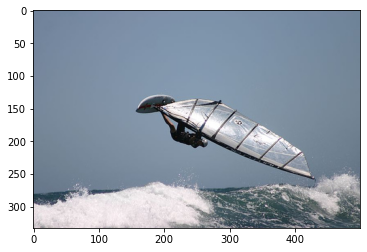

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input


def  extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat =np.any( max(yhat))
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

tokenizer = load(open('tokenizer.p', 'rb'))
max_length = 34





#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'

img_path = 'Flicker8k_Dataset/70995350_75d0698839.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('model_0.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)